# Importing of libraries

In [6]:
#import necessary libraries
import numpy as np
import pandas as pd

#import visualisation libraries
import matplotlib.pyplot as plt
import seaborn as sb
sb.set()

#import Statistics libraries
from scipy import stats
from scipy.stats import norm

#import model libraries
import sklearn as sk
import sklearn.datasets as skd
import sklearn.ensemble as ske

In [7]:
raw_data = pd.read_csv('jobs_in_data_2024.csv')

# Data Analysis

In [8]:
#checking for unique values
for column in raw_data.columns:
    num_distinct_values = len(raw_data[column].unique())
    print(f"{column}: {num_distinct_values} distinct values")

work_year: 5 distinct values
experience_level: 4 distinct values
employment_type: 4 distinct values
job_title: 149 distinct values
salary: 2229 distinct values
salary_currency: 12 distinct values
salary_in_usd: 2578 distinct values
employee_residence: 86 distinct values
work_setting: 3 distinct values
company_location: 74 distinct values
company_size: 3 distinct values
job_category: 10 distinct values


In [9]:
raw_data.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,work_setting,company_location,company_size,job_category
0,2024,Entry-level,Freelance,Applied Data Scientist,30000,USD,30000,United Kingdom,Remote,United Kingdom,M,Data Science and Research
1,2024,Executive,Full-time,Business Intelligence,230000,USD,230000,United States,In-person,United States,M,BI and Visualization
2,2024,Executive,Full-time,Business Intelligence,176900,USD,176900,United States,In-person,United States,M,BI and Visualization
3,2024,Senior,Full-time,Data Architect,171210,USD,171210,Canada,In-person,Canada,M,Data Architecture and Modeling
4,2024,Senior,Full-time,Data Architect,92190,USD,92190,Canada,In-person,Canada,M,Data Architecture and Modeling


**Now because salary is affected by inflation rate for different years, lets bring all the salaries up to date 
with what it would be currently**

**sources:**
- [US inflation rates](https://www.investopedia.com/inflation-rate-by-year-7253832)
- [Global inflation rates](https://www.macrotrends.net/global-metrics/countries/WLD/world/inflation-ratecpi#:~:text=World%20inflation%20rate%20for%202022,a%200.23%25%20decline%20from%202018)


# Adjust Salary Function

In [10]:
# inflation rates
us_inflation_rates = {2020: 0.0140, 2021: 0.070, 2022: 0.065, 2023: 0.034}
global_inflation_rates = {2020: 0.0193 , 2021: 0.0348, 2022: 0.087, 2023: 0.068}


# function to adjust salary
def adjust_salary(row):
    year = row['work_year']
    original_salary = row['salary_in_usd']
    currency = row['salary_currency']
    if year == 2024:
        return original_salary
        
    adjusted_salary = original_salary
    for y in range(year, 2024):
        if currency == 'USD':
            inflation_rate = us_inflation_rates[y]
        else:
            inflation_rate = global_inflation_rates[y]
        adjusted_salary *= (1 + inflation_rate)
    return adjusted_salary

# apply function to dataset
raw_data['adjust_salary'] = raw_data.apply(adjust_salary, axis=1)

In [11]:
raw_data['adjust_salary']

0         30000.000000
1        230000.000000
2        176900.000000
3        171210.000000
4         92190.000000
             ...      
14194    194418.625500
14195    492253.820230
14196    177922.499700
14197    125453.036709
14198    119479.082580
Name: adjust_salary, Length: 14199, dtype: float64

# UNI-VARIATIVE ANALYSIS

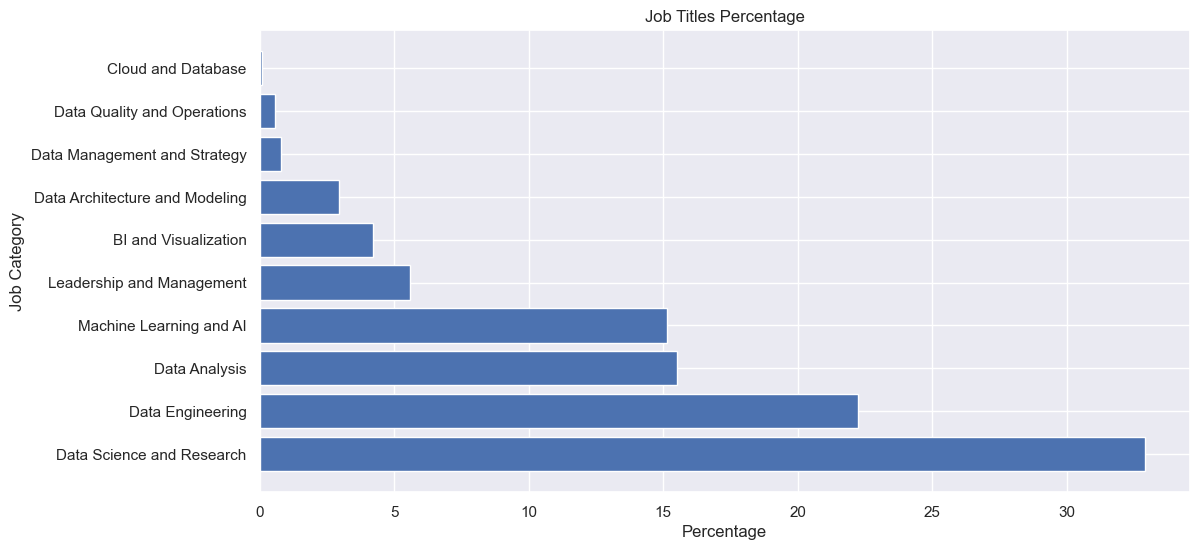

In [12]:
value_counts = raw_data['job_category'].value_counts(normalize=True) * 100

fig, ax = plt.subplots(figsize=(12,6))
top_n = min(17, len(value_counts))
ax.barh(value_counts.index[:top_n], value_counts.values[:top_n])
ax.set_xlabel('Percentage')
ax.set_ylabel('Job Category')
ax.set_title('Job Titles Percentage')
plt.show()

## Salary distribution across different employment types

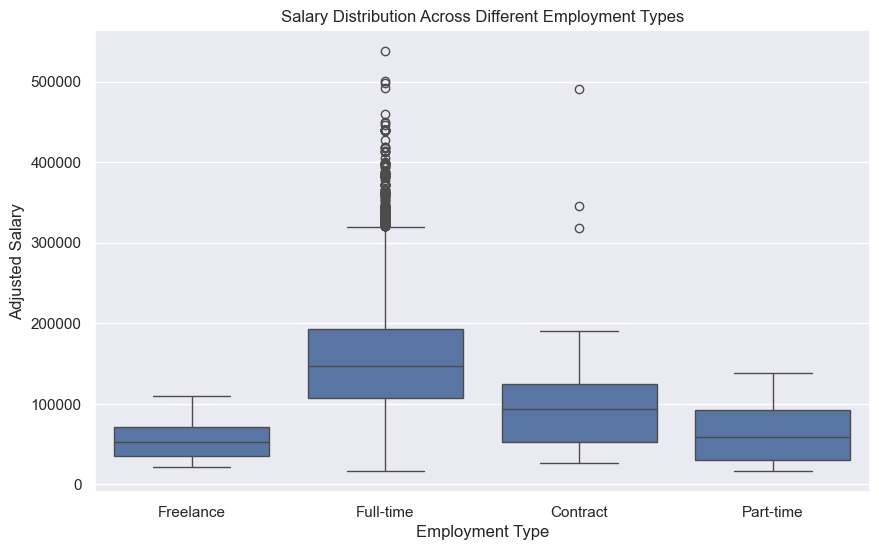

In [13]:

plt.figure(figsize=(10, 6))
sb.boxplot(data=raw_data, x='employment_type', y='adjust_salary')
plt.title('Salary Distribution Across Different Employment Types')
plt.xlabel('Employment Type')
plt.ylabel('Adjusted Salary')
plt.show()

**Purely from analysis, this means that Full-time jobs pay the best, we should then consider only Full-time jobs in our later analysis**

## Distribution of Adjusted Salary

adjust_salary: mu = 154710.67, sigma = 66196.13
adjust_salary: Skewness: 0.74
adjust_salary: Kurtosis: 0.93


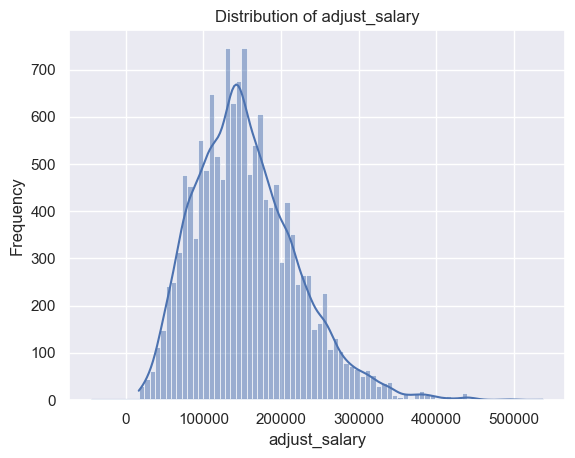

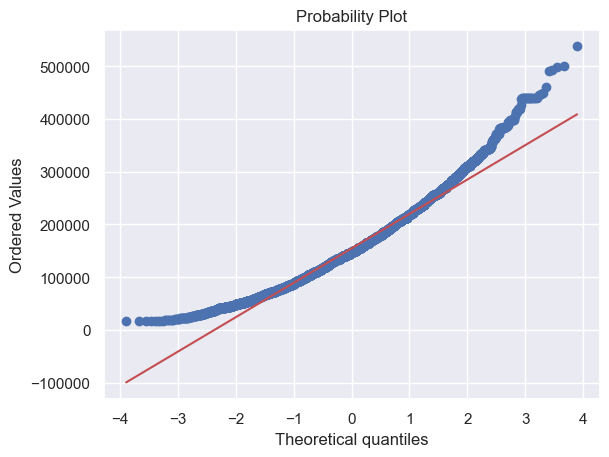

In [14]:
# Create list of the columns to analyze
columns = ['adjust_salary']

# Loop over columns and plot distribution of each variable
for col in columns:
    # Plot the distribution of the data
    sb.histplot(raw_data[col], kde=True)
    
    # Fit a normal distribution to the data
    (mu, sigma) = stats.norm.fit(raw_data[col])
    print('{}: mu = {:.2f}, sigma = {:.2f}'.format(col, mu, sigma))
    
    # Calculate skewness and kurtosis of the data
    print('{}: Skewness: {:.2f}'.format(col, raw_data[col].skew()))
    print('{}: Kurtosis: {:.2f}'.format(col, raw_data[col].kurt()))
    
    # Add fitted normal distribution to the plot
    x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
    y = stats.norm.pdf(x, mu, sigma)
    plt.plot(x, y, label='Normal fit')
    
    # Add labels and title to the plot
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.title('Distribution of {}'.format(col))

    # Plot the QQ-plot
    fig = plt.figure()
    stats.probplot(raw_data[col], plot=plt)

    plt.show()
    

# Creating a scale using normalization for selected variables
- this is done with the intention to quantify how favorable a selected variable is in determining the best job
- How to calculate normalization:
  1. Calculate range of data set. i.e. Range of x = x max - x min
  2. Subtract minimum x value from value at current data point. i.e. x current - x min
  3. Insert value into formula and divide
     - Equation is as follows: x normalized = (x - x min) / range of x

## Selected columns that might affect how good a job
- work_year
- experience_level (not numerical, need to quantify into a number)
- employment_type (not numerical, need to quantify into a number)
- adjust_salary

In [15]:
# these are the parameters set for the function usage below
input_csv = 'jobs_in_data_2024.csv'
output_csv = 'modified_dataset.csv'
selected_columns = ['work_year', 'adjust_salary']

## Normalizer & add_to_csv functions

In [16]:
# function to calculate normalized values for selected column
# using the adjusted salary as an example...

def normalizer(col):
    '''
    Parameters:
        col: the column of data to be normalized

    Returns:
        list: the normalized column of data
    '''
    min_val = min(col)
    max_val = max(col)
    normalized_data = [(x - min_val)/(max_val - min_val) for x in col]
    return normalized_data

# function to write the normalization to a new csv with side by side comparison
def add_normalize_to_csv(input_csv, output_csv, column_name):
    """
    Parameters:
        input_csv (str): Path to input CSV file
        output_csv (str): Path to output CSV file
        column_name (str): name of the column to be normalized
    """
    # Read CSV file
    df = pd.read_csv(input_csv)
    # normalize desired column
    normalized_column = normalizer(raw_data[column_name])

    # add normalized column to dataframe
    df[column_name + '_normalized'] = normalized_column

    # Write the dataframe back to CSV
    df.to_csv(output_csv, index=False)

## Normalizing of data

In [17]:
for name in selected_columns:
    add_normalize_to_csv(input_csv, output_csv, name)

## Creation of dummy variables for categorical factors
- experience_level
- employment_type

In [90]:
# function to add a new column to csv
def add_to_csv(df, column_name):
    df[column_name].to_csv('modified_dataset.csv', index=False, mode='a+')

# function to create boolean columns for categorical variables
def create_bool_col(df, column_name):
    df_encoded = pd.get_dummies(df, columns=[column_name]).astype(int)

    for column in df_encoded.columns:
        add_to_csv(df_encoded, column)

### Experience_level

In [86]:
# for experience level
unique_values = raw_data['experience_level'].unique()
print(unique_values)

['Entry-level' 'Executive' 'Senior' 'Mid-level']


**Now that we have the possible variables, we need to convert them to numerical values**

In [93]:
# Read csv
dataframe = pd.read_csv(input_csv)

# Creating new columns such as Full-Time, Entry-Level which will either be 0 or 1
df_encoded = pd.get_dummies(dataframe, columns=['experience_level'])

for column in df_encoded.columns:
    add_to_csv(df_encoded, column)

### Employment_type

In [21]:
# for employment type
unique_values = raw_data['employment_type'].unique()
print(unique_values)

['Freelance' 'Full-time' 'Contract' 'Part-time']


In [22]:
# read csv


**Now let's check the new column**

In [23]:
df = pd.read_csv(input_csv)
df['employment_type_favor'].unique()

array([0, 3, 1, 2], dtype=int64)

# Random Forest Regression

In [35]:
# importing libraries
import sklearn as sk
import sklearn.ensemble as ske
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

In [38]:
# read dataset
df = pd.read_csv('data_set.csv')


# Choose all predictors except target 
predictors = [x for x in df.columns if x not in ['job_title']]
gmb0 = ske.GradientBoostingClassifier(random_state=10)
gmb0.fit(df, predictors)

ValueError: could not convert string to float: 'Entry-level'